# Histopathologic Cancer Detection - Training

In this notebook, we've create an algorithm to identify metastatic cancer in small image patches (92 by 92 pixels) taken from larger digital pathology scans. The data we've used is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, that you can find here https://github.com/basveeling/pcam (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates, which we've used in this model) .

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:
*PCam packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.*

**Dataset**

In this dataset, we are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image, which we will demonstrate in the prediction phase.

**Model**

For the model, we have fine-tuned a NASNet network to fit this particular task, which we will train in order to get a good accuracy on the validation set. Actually, This model has enabled us to obtain an AUC-ROC score of 0.9526 which is good enough to point out with a good accuracy the regions where the cancer probably is present, thus greatly contributing to a doctor's diagnosis.       

# 1. Importing the necessary libraries  

In [44]:
import numpy as np
import pandas as pd

import os
from glob import glob
from random import shuffle
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from imgaug import augmenters as iaa
import imgaug as ia

# 2. Loading the data

Here we load the image data on which we will train and validate our model, and visualize some of the labels and images in order to get a better idea about the problem at hand.

In [2]:
df_train = pd.read_csv("../input/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [4]:
labeled_files = glob('../input/train/*.tif')
test_files = glob('../input/test/*.tif')

In [5]:
print("labeled_files size :", len(labeled_files))
print("test_files size :", len(test_files))

labeled_files size : 220025
test_files size : 57458


Text('Tumor tissue samples')

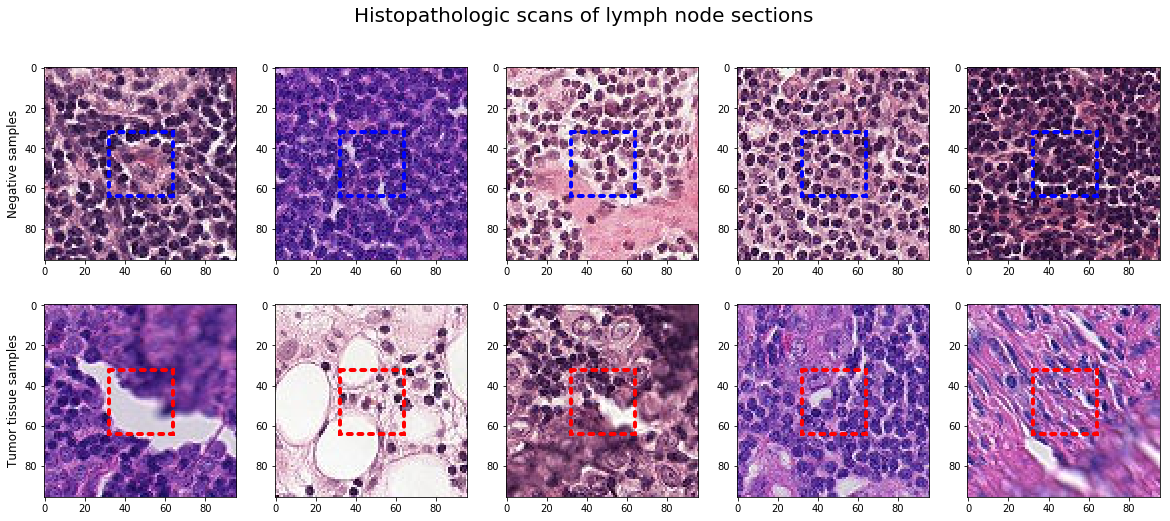

In [3]:
from sklearn.utils import shuffle

def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

# random sampling
shuffled_data = shuffle(df_train)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

# 3. Preprocessing

In this part, we define the train and validation split of the data, as well as the image augmentation which will take place during the training of the model. This is a necessary step for the model to be generalizable on future predictions. 

In [6]:
train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)

In [7]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)
    

# 4. Defining the model

We define the architecture of the model, which is a NASNetMobile neural network, pre-trained on imagenet database, which we have found to work well with this dataset.
In addition, we add a few other layers to obtain the final predictions. the pre-loaded weights will help us to get a headstart on this particular problem.

In [15]:
def get_model_classif_nasnet():
    inputs = Input((96, 96, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(96, 96, 3))#, weights=None
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [19]:
model = get_model_classif_nasnet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_9[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
flatten_5 

# 5. Training the model

We proceed to train the model on the data while validating both the loss and the accuracy score in order to get a good idea on its performance. 

In [20]:
batch_size=32
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)
batch_size=64
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=6, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)


Epoch 1/2
6188/6188 [==============================] - 3509s 567ms/step - loss: 0.4096 - acc: 0.8146 - val_loss: 0.4131 - val_acc: 0.8068

Epoch 00001: val_loss improved from inf to 0.41314, saving model to model.h5
Epoch 2/2
6188/6188 [==============================] - 3367s 544ms/step - loss: 0.2982 - acc: 0.8722 - val_loss: 0.1840 - val_acc: 0.9295

Epoch 00002: val_loss improved from 0.41314 to 0.18396, saving model to model.h5
Epoch 1/6
3094/3094 [==============================] - 2557s 826ms/step - loss: 0.2481 - acc: 0.8967 - val_loss: 0.1596 - val_acc: 0.9402

Epoch 00001: val_loss improved from 0.18396 to 0.15960, saving model to model.h5
Epoch 2/6
3094/3094 [==============================] - 2644s 855ms/step - loss: 0.2341 - acc: 0.9026 - val_loss: 0.1567 - val_acc: 0.9388

Epoch 00002: val_loss improved from 0.15960 to 0.15673, saving model to model.h5
Epoch 3/6
3094/3094 [==============================] - 2586s 836ms/step - loss: 0.2234 - acc: 0.9076 - val_loss: 0.1877 - va

# 6. Assessing performance

We finally load the best model (saved thanks to checkpoint on the validation loss metric), and assess the final performance thanks to AUC-ROC score and a confusion matrix, which will give us an idea on the sensivity and specifity of the model. 

In [21]:
model.load_weights(h5_path)

In [60]:
val_preds = []
val_ids = []

In [ ]:
for batch in chunker(val, batch_size):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    val_preds += preds_batch
    val_ids += ids_batch

In [ ]:
val_preds_cat = (np.array(val_preds) > 0.5).astype(int)

In [47]:
y_val = np.array([id_label_map[get_id_from_file_path(x)] for x in val])
print("Accuracy is: ", accuracy_score(y_val, val_preds_cat))
print("AUC_ROC score is: ", roc_auc_score(y_val, val_preds))

AUC_ROC score is:  0.952646416031849


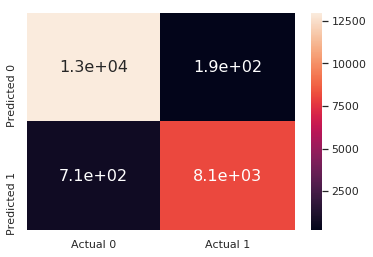

In [42]:
df_cm = pd.DataFrame(confusion_matrix(y_val, val_preds_cat), index=["Predicted 0", "Predicted 1"], columns=["Actual 0", "Actual 1"])
sns.set(font_scale=1.0) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})